In [207]:
%pip install matplotlib numpy graphviz torch

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

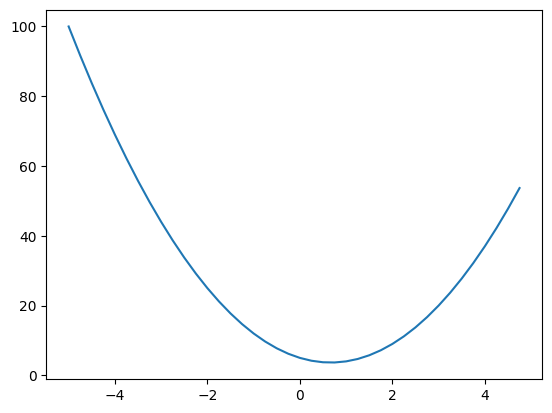

In [4]:
# Plotting
xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs,ys)

In [201]:
# Build out the value object

class Value:
    
    def __init__(self, data, _children=(),_op='', label=''):
        self.data = data
        self._prev = set(_children) # tuple to set for efficiency
        self._op = _op
        self.label = label
        self.grad = 0.0 # default is no effect
        self._backward = lambda : None
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self,other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad # Local deriv * out's deriv
            other.grad += 1.0 * out.grad
        
        out._backward = _backward
        return out
    
    def __radd__(self, other): # other + self
        return self+other
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self,other), '*')
        
        def _backward():
            self.grad += other.data * out.grad # Local deriv * out's deriv
            other.grad += self.data * out.grad

        out._backward = _backward
        return out
    
    def __rmul__(self,other): # other * self
        return self * other
    
    def __pow__(self, other): # self**other
        assert isinstance(other, (int,float)), "only supporting int/float for now"
        out = Value(self.data**other, (self,), f'**{other}')
        
        def _backward():
            self.grad += other*self.data**(other-1)*out.grad # power rule
            
        out._backward = _backward
        
        return out
    
    def __truediv__(self, other): # other/self
        return self * other**-1
    
    def __neg__(self): # -self
        return self*-1
    
    def __sub__(self, other): # self - other
        return self + (-other)
        
    def tanh(self):
        n = self.data
        t = (np.exp(2*n)-1)/(np.exp(2*n)+1)
        out = Value(t, (self,), 'tanh')
        
        def _backward():
            self.grad += (1.0 - t**2)*out.grad # Local deriv * out's deriv
        
        out._backward = _backward
        
        return out
    
    def exp(self):
        n = self.data
        t = np.exp(n)
        out = Value(t, (self,), 'exp')
        
        def _backward():
            self.grad += t*out.grad # Local deriv * out's deriv
        
        out._backward = _backward
        
        return out
    
    def backward(self):
            self.grad = 1.0
            topo = []
            visited = set()
            def build_topo(v):
                if v not in visited:
                    visited.add(v)
                    for ch in v._prev:
                        build_topo(ch)
                    topo.append(v)
            build_topo(self)
            for node in reversed(topo):
                node._backward()


In [202]:
a= Value(1.0)
b= Value(2.0)
a-b

Value(data=-1.0)

In [54]:
from graphviz import Digraph

def trace(root):
    # build set of nodes and edges
    nodes, edges = set(), set()
    def dfs(v):
        if v not in nodes:
            nodes.add(v)
            for ch in v._prev:
                edges.add((ch,v))
                dfs(ch)
    dfs(root)
    return nodes,edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir':'LR'}) # left to right , default is up to down
    
    nodes,edges = trace(root)
    for n in nodes:
        uid = str(id(n)) 
        # for any val in the graph create a rectangular 'record' node for it
        dot.node(name=uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label,n.data, n.grad),shape = 'record')
        if n._op:
            # if this val is a result of an op, create a op node for it
            dot.node(name=uid+n._op, label=n._op)
            dot.edge(uid+n._op,uid)
    for n1,n2 in edges:
        # connect n1 to op node of n2
        dot.edge(str(id(n1)), str(id(n2))+n2._op)
    return dot


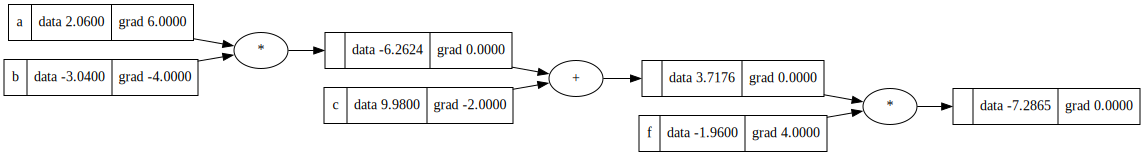

In [96]:
draw_dot(L)

In [94]:
def lol():
    
    h=0.001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d=e+c; d.label='d'
    f = Value(-2.0, label='f')
    L = d*f; L.label='L'
    L1 = L.data
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d=e+c; d.label='d'
    f = Value(-2.0, label='f')
    L = d*f; L.label='L'
    L2 = L.data
    
    print((L2-L1)/h)
    
lol()

0.0


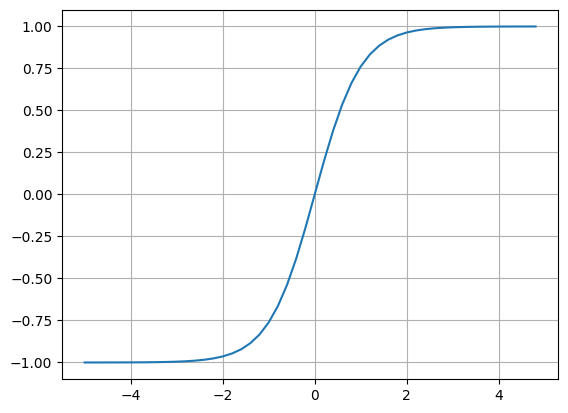

In [97]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [203]:
# inputs 
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias
b = Value(6.8813735870195432, label='b')
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label='x1w1+x2w2'
n=x1w1x2w2+b;n.label='n'
o = n.tanh(); o.label = 'o'
o.backward()

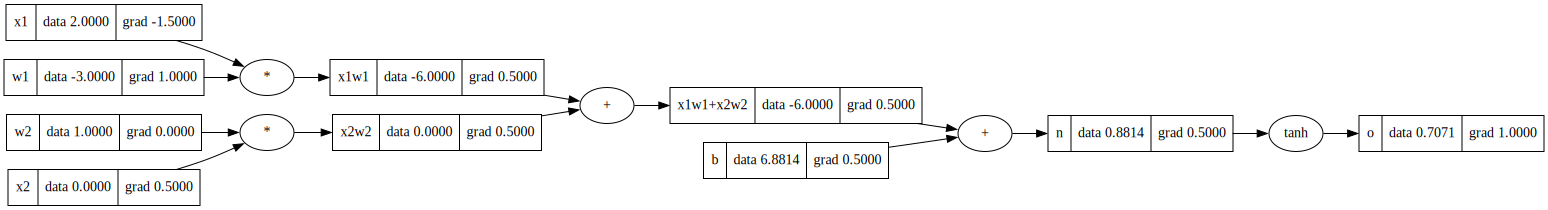

In [204]:
draw_dot(o)

In [205]:
# inputs 
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias
b = Value(6.8813735870195432, label='b')
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label='x1w1+x2w2'
n=x1w1x2w2+b;n.label='n'

# break down tanx o = n.tanh(); o.label = 'o'
e = (2*n).exp();e.label='e'
o = (e-1)/(e+1);o.label='o'
o.backward()

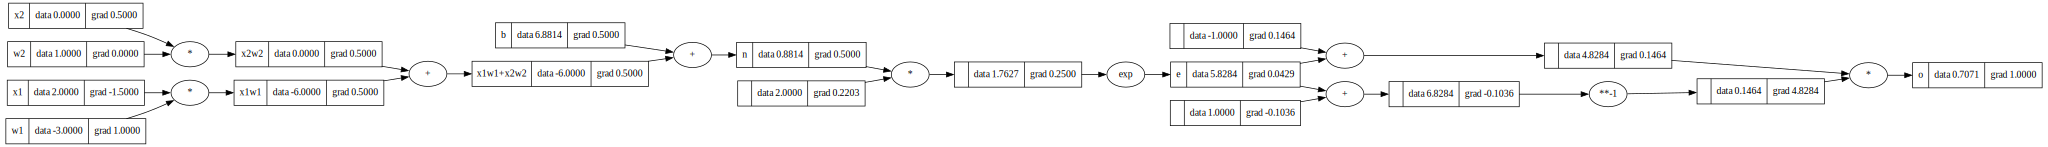

In [206]:
draw_dot(o)

In [209]:
import torch

In [214]:


x1 = torch.tensor([2.0]).double(); x1.requires_grad=True
w1 = torch.tensor([-3.0]).double(); w1.requires_grad=True

x2 = torch.tensor([0.0]).double(); x2.requires_grad=True
w2 = torch.tensor([1.0]).double(); w2.requires_grad=True

b = torch.tensor([6.8813735870195432]).double(); b.requires_grad=True
n=x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('----')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())


0.7071066904050358
----
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [232]:
import random

In [270]:

class Neuron:
    
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        
    def __call__(self, x):
        # w*x + b
        act = sum((wi*xi for wi,xi in zip(self.w,x)),self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self,x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs)==1 else outs
    
    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]
    
class MLP:
    
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i],sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for l in self.layers for p in l.parameters()]
    


In [370]:
x = [2.0,3.0,-1]
n = MLP(3,[4,4,1])
o=n(x)

In [395]:
xs = [
    [2.0,3.0,-1.0],
    [3.0,-1.0,0.5],
    [0.5,1.0,1.0],
    [1.0,1.0,-1.0]
]
ys = [1.0,-1.0,-1.0,1.0] # desired targets
ypred = [n(x) for x in xs]
ypred

[Value(data=0.9881563543538985),
 Value(data=-0.9749769113376917),
 Value(data=-0.9860749400845154),
 Value(data=0.9770167669852184)]

In [396]:
# training loop
for k in range(200):
    #forward pass
    ypred = [n(x) for x in xs]
    loss = sum([(yout-ygt)**2for ygt,yout in zip(ys,ypred)])/len(ys)
    
    #backward pass
    loss.backward()
    
    # update
    for p in n.parameters():
        p.data += - 0.01*p.grad # stochastic gradient descent
        p.grad = 0 # zero grad to avoid accumulate
    if k%50==0:
        print(k,loss)

0 Value(data=0.00037214080046343585)
50 Value(data=0.00036940135152622674)
100 Value(data=0.0003667001032945121)
150 Value(data=0.00036403627993982076)
